# Analyze Sentiment for Forum Data
This notebook loads the sentiment data and explores results

## Data Sources
- youbemom-merged.db (with sentiment scores from 2.0-Sentiment-Create_Scores.ipynb)

## Changes
- 2020-12-13: Created

## Database Structure
- threads
 - id: automatically assigned
 - url: url of top post
 - subforum: subforum of post
 - dne: post does not exist
- posts
 - id: automatically assigned
 - family_id: thread->id
 - message_id: the unique id of the message from the html
 - parent_id: id of post this post is responding to, 0 if top post
 - date_recorded: date the data is fetched
 - date_created: date the data was created
 - title: title of the post
 - body: body of the post
 - subforum: subforum of post
 - deleted: has post been deleted

## TODO
- Does python have a regression function for continuous dependent variables between 0 and 1 or will I have to use R/Stata for a fractional regression model?
- Set up functions for the plots so I can plug in the variable I want to see
- Does sentiment differ between parents and children in threads?
 - Is sentiment more negative after negative posts? More positive after positive posts?
- Is there a time-dependent function here?
 - Seasonality?
 - Does tweaking the time period cutoffs affect the significance?
- Frequency distribution of words
- Robustness checks of different samples

## Imports

In [1]:
import sqlite3
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from scipy.stats import ttest_ind, kde
from datetime import datetime
# from nltk.probability import FreqDist
from nltk.tokenize import RegexpTokenizer #, word_tokenize
from nltk.corpus import stopwords
import string
import re
from pathlib import Path
import matplotlib.pyplot as plt
import math
from statsmodels.formula.api  import ols
from youbemom import create_connection

## Functions

In [46]:
def ttest_sentiment(df, v):
    """ run a t-test on the sentiment scores for
        before and during the pandemic
    :param df: data frame
    :param v: the variable name to t-test on
    :return: nothing, prints ttest results
    """
    group_before = df.where(df['before'])[v].dropna()
    group_during = df.where(df['during'])[v].dropna()
    result = ttest_ind(group_before, group_during, equal_var=False, nan_policy="omit")
    print('\n')
    l = len(v)
    print(' '*(l - 8) + 'variable    before    during statistic    pvalue')
    print(v + '  {:1.6f}  {:1.6f} {:+1.6f}  {:1.6f}'.format(group_before.mean(), group_during.mean(), result.statistic, result.pvalue))

In [53]:
def format_data(df):
    """ format the data frame from sql so dates are in
        datetime format and booleans are bools not ints
    :param df: data frame
    :return df: formatted data frame
    """
    df['date_recorded'] = pd.to_datetime(df['date_recorded'])
    df['date_created'] = pd.to_datetime(df['date_created'])
    df['is_parent'] = df['is_parent'] == 1
    df['deleted'] = df['deleted'] == 1
    df['before'] = df['before'] == 1
    df['during'] = df['during'] == 1
    df['march'] = df['march'] == 1
    return df

In [72]:
def compare_parent_child(df):
    parents = df[df["is_parent"]]
    parents = parents[["family_id","neg_sentiment","pos_sentiment","compound_sentiment"]]
    children = df[~df["is_parent"]]
    children = children[["family_id","neg_sentiment","pos_sentiment","compound_sentiment"]]
    children_ave = children.groupby("family_id", as_index=False).mean()
    compare = pd.merge(left=parents, right=children_ave, on="family_id", how="inner", suffixes=['_p','_c'])
    compare['pos_diff'] = compare['pos_sentiment_p'] - compare['pos_sentiment_c']
    compare['neg_diff'] = compare['neg_sentiment_p'] - compare['neg_sentiment_c']
    compare['compound_diff'] = compare['compound_sentiment_p'] - compare['compound_sentiment_c']
    return compare

In [101]:
def seasonality(df, name, var):
    grouping_ave = df.groupby([var])['compound_sentiment'].mean()
    path_sen = path_parent / "clean_data" / "sentiment_{0}_{1}.csv".format(name, var)
    path_sen = str(path_sen)
    grouping_ave.to_csv(path_sen)
    print(grouping_ave)

## File Locations

In [3]:
p = Path.cwd()
path_parent = p.parents[0]

In [4]:
path_db = path_parent / "database" / "youbemom-merged.db"
path_db = str(path_db)

## Load Data
Counts of posts in each subforum

In [5]:
counts_sql = '''
    SELECT subforum, COUNT(family_id), MIN(date_created), MAX(date_created)
    FROM posts
    GROUP BY subforum
'''

In [6]:
conn = sqlite3.connect(path_db)
counts = pd.read_sql_query(counts_sql, conn)

In [8]:
counts.head(16)

,subforum,COUNT(family_id),MIN(date_created),MAX(date_created)
0,boston,230,2018-01-27 17:21:00,2020-11-23 00:23:00
1,chicago,193,2018-03-05 14:40:00,2020-12-08 13:50:30
2,elementary,3543,2013-12-05 21:43:00,2020-11-30 20:52:00
3,expecting,872,2018-01-24 02:43:00,2020-11-23 21:01:00
4,los-angeles,263,2018-01-09 20:58:00,2020-12-02 02:07:00
5,new-york-city,6297,2018-01-07 11:37:00,2020-11-28 03:45:00
6,newborn,2036,2013-11-06 20:55:00,2020-11-29 23:39:00
7,nyc-schools,2211,2018-01-01 16:03:00,2020-12-04 16:49:00
8,preschool,3000,2013-12-10 03:58:00,2020-11-23 14:34:00
9,single-parents,337,2018-02-07 11:29:00,2020-11-23 16:22:00


Special needs subforum

In [9]:
sn_sql = ''' SELECT * FROM posts WHERE subforum="special-needs" '''

In [81]:
sn = pd.read_sql_query(sn_sql, conn)

In [82]:
sn = format_data(sn)

Toddler subforum: generate a 10% sample of family_ids to make processing easier

In [12]:
td_ids_sql = ''' SELECT family_id FROM threads WHERE subforum="toddler" '''

In [13]:
td_ids = pd.read_sql_query(td_ids_sql, conn)

In [15]:
id_10per_sample = td_ids.sample(frac = 0.1, random_state = 281)

In [17]:
temp_table_sql = ''' CREATE TEMPORARY TABLE temp(id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE, family_id INTEGER); '''

In [18]:
cur = conn.cursor()
cur.execute(temp_table_sql)

In [19]:
id_10per_sample.to_sql('temp', conn, if_exists='append', index=False)

In [20]:
td_sql = ''' 
    SELECT * 
    FROM posts 
    WHERE subforum="toddler" 
        AND family_id IN (SELECT family_id FROM temp)
'''

In [83]:
td = pd.read_sql_query(td_sql, conn)

In [84]:
td = format_data(td)

## Compare Sentiment

### 1. Subsets in correct date range: 2018-01-01 to 2020-11-30

In [85]:
mask = (td['date_created'] >= pd.Timestamp(2018, 1, 1, 0, 0, 0)) & (td['date_created'] < pd.Timestamp(2020, 12, 1, 0, 0, 0))
td_sub = td.loc[mask]

In [86]:
mask = (sn['date_created'] >= pd.Timestamp(2018, 1, 1, 0, 0, 0)) & (sn['date_created'] < pd.Timestamp(2020, 12, 1, 0, 0, 0))
sn_sub = sn.loc[mask]

### 2. Comparing sentiment before and during pandemic with a t-test

In [61]:
for df in [sn_sub, td_sub]:
    print("\nGROUP\n")
    ttest_sentiment(df, 'neg_sentiment')
    ttest_sentiment(df, 'neu_sentiment')
    ttest_sentiment(df, 'pos_sentiment')
    ttest_sentiment(df, 'compound_sentiment')


GROUP



     variable    before    during statistic    pvalue
neg_sentiment  0.065994  0.070662 -2.666893  0.007673


     variable    before    during statistic    pvalue
neu_sentiment  0.782411  0.767375 +4.311199  0.000016


     variable    before    during statistic    pvalue
pos_sentiment  0.118489  0.116065 +1.041510  0.297674


          variable    before    during statistic    pvalue
compound_sentiment  0.125809  0.111455 +2.330966  0.019783

GROUP



     variable    before    during statistic    pvalue
neg_sentiment  0.087440  0.088576 -3.806125  0.000141


     variable    before    during statistic    pvalue
neu_sentiment  0.772217  0.769809 +5.174986  0.000000


     variable    before    during statistic    pvalue
pos_sentiment  0.124902  0.119395 +15.393640  0.000000


          variable    before    during statistic    pvalue
compound_sentiment  0.056082  0.041731 +20.995239  0.000000


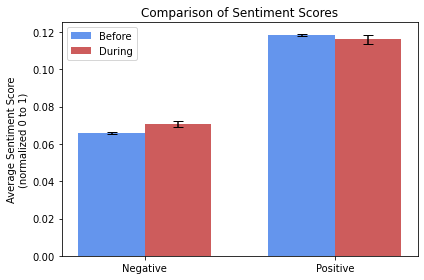

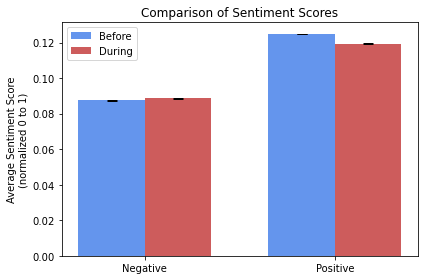

In [96]:
for df in [sn_sub, td_sub]:
    fig, ax = plt.subplots()
    width = 0.35
    sentiments = ['Negative', 'Positive']
    x_pos = np.arange(len(sentiments))

    before_mean = [df["neg_sentiment"][df['before']].mean(),
                   df["pos_sentiment"][df['before']].mean()]
    before_se = [df["neg_sentiment"][df['before']].std()/math.sqrt(len(df["neg_sentiment"][df['before']])),
                 df["pos_sentiment"][df['before']].std()/math.sqrt(len(df["pos_sentiment"][df['before']]))]
    during_mean = [df["neg_sentiment"][df['during']].mean(),
                   df["pos_sentiment"][df['during']].mean()]
    during_se = [df["neg_sentiment"][df['during']].std()/math.sqrt(len(df["neg_sentiment"][df['during']])),
                 df["pos_sentiment"][df['during']].std()/math.sqrt(len(df["pos_sentiment"][df['during']]))]

    rects_before = ax.bar(x_pos - width/2, before_mean, width, yerr=before_se,
                    label='Before', capsize=5, color="cornflowerblue")
    rects_during = ax.bar(x_pos + width/2, during_mean, width, yerr=during_se,
                    label='During', capsize=5, color="indianred")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Average Sentiment Score\n(normalized 0 to 1)')
    ax.set_title('Comparison of Sentiment Scores')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(sentiments)
    ax.legend()
    fig.tight_layout()
#     plt.savefig('../plots/sentiment_neg_pos.png')
    plt.show()

### 3. Comparing sentiment of parent and child posts

In [73]:
for df in [sn_sub, td_sub]:
    print("\nGROUP\n")
    compare = compare_parent_child(df)
    est_pos = ols(formula = 'pos_sentiment_c ~ pos_sentiment_p', data = compare).fit()
    print(est_pos.summary())
    est_neg = ols(formula = 'neg_sentiment_c ~ neg_sentiment_p', data = compare).fit()
    print(est_neg.summary())
    est_compound = ols(formula = 'compound_sentiment_c ~ compound_sentiment_p', data = compare).fit()
    print(est_compound.summary())


GROUP

                            OLS Regression Results                            
Dep. Variable:        pos_sentiment_c   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     106.9
Date:                Sun, 13 Dec 2020   Prob (F-statistic):           8.71e-25
Time:                        15:40:36   Log-Likelihood:                 3951.0
No. Observations:                4753   AIC:                            -7898.
Df Residuals:                    4751   BIC:                            -7885.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.1124      0.

So this suggests if a parent comment's negative sentiment increases, the children's negative sentiment will increase as well. Perhaps redo this analysis on each observation rather than the average children's sentiment.

### 4. Compare density of compound sentiment

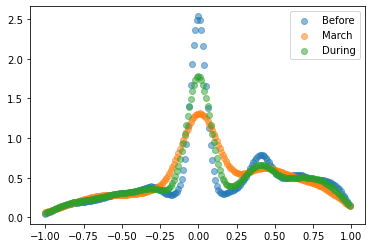

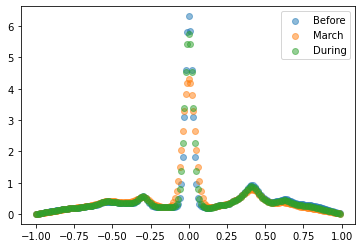

In [75]:
for df in [sn_sub, td_sub]:
    density_before = kde.gaussian_kde(df["compound_sentiment"][df['before']])
    density_march = kde.gaussian_kde(df["compound_sentiment"][df['march']])
    density_during = kde.gaussian_kde(df["compound_sentiment"][df['during']])
    x = np.arange(-1.0, 1.0, 0.01)
    plt.scatter(x, density_before(x), alpha=0.5, label="Before")
    plt.scatter(x, density_march(x), alpha=0.5, label="March")
    plt.scatter(x, density_during(x), alpha=0.5, label="During")
    plt.legend(loc="upper right")
    plt.show()

<ipython-input-90-655d7c6293a4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date_created'], format="%Y-%m-%d")


                      id     family_id   deleted  before  during  march  \
date                                                                      
2020-10-18  1.477079e+07  1.371649e+06  0.000000   False    True  False   
2020-09-05  1.402768e+07  1.299854e+06  0.000000   False    True  False   
2020-06-18  1.264701e+07  1.169270e+06  0.000000   False    True  False   
2020-08-15  1.361468e+07  1.259230e+06  0.000000   False    True  False   
2020-08-02  1.340166e+07  1.239789e+06  0.000000   False    True  False   
2020-11-20  1.527859e+07  1.424906e+06  0.000000   False    True  False   
2020-08-13  1.361410e+07  1.259234e+06  0.000000   False    True  False   
2020-10-01  1.446394e+07  1.340331e+06  0.000000   False    True  False   
2020-06-29  1.279610e+07  1.183548e+06  0.333333   False    True  False   
2020-05-08  1.188642e+07  1.095597e+06  0.000000   False    True  False   
2020-06-20  1.265685e+07  1.170364e+06  0.000000   False    True  False   
2020-10-11  1.466014e+07 

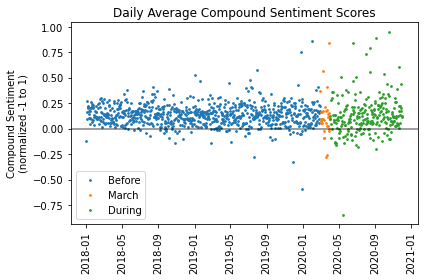

<ipython-input-90-655d7c6293a4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date_created'], format="%Y-%m-%d")


                      id     family_id   deleted  before  during  march  \
date                                                                      
2020-09-04  1.402759e+07  1.299833e+06  0.027092   False    True  False   
2020-09-20  1.427554e+07  1.322179e+06  0.024188   False    True  False   
2020-09-25  1.436571e+07  1.330195e+06  0.013014   False    True  False   
2020-09-09  1.410452e+07  1.306486e+06  0.024569   False    True  False   
2020-10-18  1.479115e+07  1.373474e+06  0.030230   False    True  False   
2020-07-12  1.306149e+07  1.207909e+06  0.041850   False    True  False   
2020-08-09  1.356206e+07  1.254221e+06  0.031538   False    True  False   
2020-04-26  1.163939e+07  1.071412e+06  0.012730   False    True  False   
2020-11-14  1.534770e+07  1.432932e+06  0.022336   False    True  False   
2020-11-21  1.548375e+07  1.445435e+06  0.045791   False    True  False   
2020-06-17  1.263393e+07  1.168052e+06  0.018647   False    True  False   
2020-09-30  1.445554e+07 

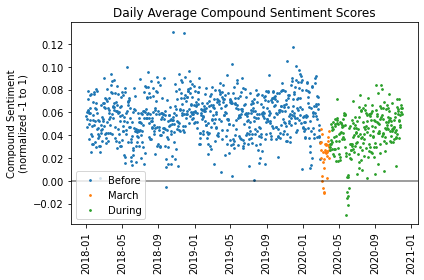

In [90]:
size = 3
for df in [sn_sub, td_sub]:
    df['date'] = pd.to_datetime(df['date_created'], format="%Y-%m-%d")
    daily_ave = df.resample('d', on='date').mean().dropna(how='all')
    daily_ave['before'] = daily_ave.index <= pd.Timestamp(2020,2,28)
    daily_ave['during'] = daily_ave.index >= pd.Timestamp(2020,4,1)
    daily_ave['march'] = ~daily_ave['before'] & ~daily_ave['during']
#     print(daily_ave[daily_ave['during']].sort_values(by='compound_sentiment', ascending=False).head(20))
    plt.scatter(daily_ave.index[daily_ave['before']], daily_ave['compound_sentiment'][daily_ave['before']], label="Before", s=size)
    plt.scatter(daily_ave.index[daily_ave['march']], daily_ave['compound_sentiment'][daily_ave['march']], label="March", s=size)
    plt.scatter(daily_ave.index[daily_ave['during']], daily_ave['compound_sentiment'][daily_ave['during']], label="During", s=size)
    plt.legend(loc="lower left")
    plt.xticks(rotation=90)
    plt.ylabel('Compound Sentiment\n(normalized -1 to 1)')
    plt.title('Daily Average Compound Sentiment Scores')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    plt.tight_layout()
    # plt.savefig('../plots/daily_ave_compound_sentiment.png')
    plt.show()

### 5. Compare post frequency over same period for special needs and toddler subforums

In [105]:
seasonality(sn_sub, "special-needs", "weekday")
seasonality(sn_sub, "special-needs", "month")
seasonality(sn_sub, "special-needs", "week_n")

weekday
Friday       0.119020
Monday       0.111130
Saturday     0.129093
Sunday       0.124005
Thursday     0.130706
Tuesday      0.128923
Wednesday    0.125623
Name: compound_sentiment, dtype: float64
month
April        0.120145
August       0.135543
December     0.118504
February     0.128265
January      0.135920
July         0.132466
June         0.124906
March        0.112394
May          0.129553
November     0.108756
October      0.122581
September    0.117748
Name: compound_sentiment, dtype: float64
week_n
1     0.168835
2     0.121707
3     0.149689
4     0.119515
5     0.138021
6     0.118786
7     0.123218
8     0.132586
9     0.130728
10    0.130151
11    0.115707
12    0.089768
13    0.093993
14    0.124559
15    0.106186
16    0.129292
17    0.115273
18    0.122451
19    0.157390
20    0.121680
21    0.120975
22    0.125768
23    0.112251
24    0.094802
25    0.134179
26    0.169947
27    0.122987
28    0.118573
29    0.153799
30    0.137298
31    0.119304
32    0.135718

In [106]:
seasonality(td_sub, "toddler", "weekday")
seasonality(td_sub, "toddler", "month")
seasonality(td_sub, "toddler", "week_n")

weekday
Friday       0.051646
Monday       0.051593
Saturday     0.051941
Sunday       0.051259
Thursday     0.048537
Tuesday      0.049098
Wednesday    0.049540
Name: compound_sentiment, dtype: float64
month
April        0.048952
August       0.049335
December     0.068623
February     0.053292
January      0.055068
July         0.048324
June         0.042351
March        0.042764
May          0.044742
November     0.056979
October      0.049688
September    0.053659
Name: compound_sentiment, dtype: float64
week_n
1     0.059253
2     0.056845
3     0.059024
4     0.053574
5     0.051800
6     0.055103
7     0.049131
8     0.057145
9     0.049852
10    0.041171
11    0.034225
12    0.044455
13    0.049472
14    0.048929
15    0.049842
16    0.045906
17    0.048295
18    0.047184
19    0.042968
20    0.051889
21    0.056642
22    0.023834
23    0.033780
24    0.043725
25    0.046277
26    0.049151
27    0.041673
28    0.047052
29    0.048331
30    0.054182
31    0.052909
32    0.043735